# **SARIMA Model**

# Step 1: SARIMA Model on time series

In [96]:
# Cell 1: Load, split, and fit once

import pandas as pd
import pmdarima as pm

# 1) LOAD & PREPARE
df = (
    pd.read_csv('/content/sample_data/milk_production.csv',
                parse_dates=['Month'],
                index_col='Month')
      .asfreq('MS')
)
# 2) SPLIT INTO TRAIN/TEST
h_test   = 12
df_train = df.iloc[:-h_test]
df_test  = df.iloc[-h_test:]

# 3) FIT SEASONAL auto_arima on the training series
auto_model = pm.auto_arima(
    df_train['Production'],
    seasonal=True, m=12,
    stepwise=True, suppress_warnings=True
)

# show the chosen orders
print(auto_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -490.431
Date:                            Tue, 01 Jul 2025   AIC                            994.862
Time:                                    09:59:59   BIC                           1015.650
Sample:                                01-01-1962   HQIC                          1003.309
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3092      2.038      1.623      0.105      -0.686       7.304
ar.L1         -0.2335      0.096   

## Transform to stationary: differencing

In [16]:
pip install pmdarima

# Optional: Auto-fit the ARIMA model

In [17]:
pip install --upgrade "numpy<2"

KeyboardInterrupt: 

In [124]:
# Cell 2: interactively choose years to forecast and plot

import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from ipywidgets import interact, IntSlider

def forecast_and_plot(years):
    # a) compute horizons
    h_future = years * 12
    h_total  = h_test + h_future

    # b) one-shot forecast (test+future)
    fc_all     = auto_model.predict(n_periods=h_total)
    fc_test    = fc_all[:h_test]
    fc_future  = fc_all[h_test:]

    # c) build timestamp indexes
    idx_test   = df_test.index
    last_train = df_train.index[-1]
    freq       = df.index.freq or pd.infer_freq(df.index) or 'MS'
    idx_future = pd.date_range(
        start=last_train + DateOffset(months=1),
        periods=h_future,
        freq=freq
    )

    # d) wrap into Series
    s_train     = df_train['Production']
    s_test      = df_test['Production']
    s_fc_test   = pd.Series(fc_test,   index=idx_test)
    s_fc_future = pd.Series(fc_future, index=idx_future)

    # e) plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(s_train,      color='blue',  linestyle='-',  label='Train')
    ax.plot(s_test,       color='green', linestyle='-',  label='Test Actual')
    ax.plot(s_fc_test,    color='red',   linestyle='--', label='Forecast on Test')
    ax.plot(s_fc_future,  color='red',   linestyle='--', linewidth=2,
            label=f'Forecast Next {years} yrs')

    # extend x‐axis
    ax.set_xlim(s_train.index[0], s_fc_future.index[-1])

    ax.set_title('Milk Production: Historical, Test & Future Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Production')
    ax.legend()
    ax.grid(True)
    plt.show()

# interactive slider: 1–10 years
max1=int(input("Enter Year limit : "))
interact(

    forecast_and_plot,
    years=IntSlider(min=1, max=max1, step=1, value=2, description='Years')
);

Enter Year limit : 10


interactive(children=(IntSlider(value=2, description='Years', max=10, min=1), Output()), _dom_classes=('widget…

In [126]:
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  138
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood                 399.115
Date:                                 Tue, 01 Jul 2025   AIC                           -784.230
Time:                                         10:26:47   BIC                           -763.790
Sample:                                              0   HQIC                          -775.923
                                                 - 138                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     4.3e-06      0.000      0.039      0.969      -0.000       0.000
ar.L1         -0.1619      0.075     -2.168      0.030      -0.308      -0.016
ar.S.L12       0.1156      1.044      0.111      0.912      -1.930       2.161
ar.S.L24       0.8783      1.041      0.844      0.399      -1.162       2.919
ma.S.L12       0.3176      1.056      0.301      0.764      -1.753       2.388
ma.S.L24      -0.4763      0.640     -0.744      0.457      -1.731       0.779
sigma2         0.0001    1.5e-05      8.288      0.000    9.48e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                18.96
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.70
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


Test Set Evaluation Metrics:
  MAE: 12.31
  RMSE: 13.94
  MAPE: 1.40%


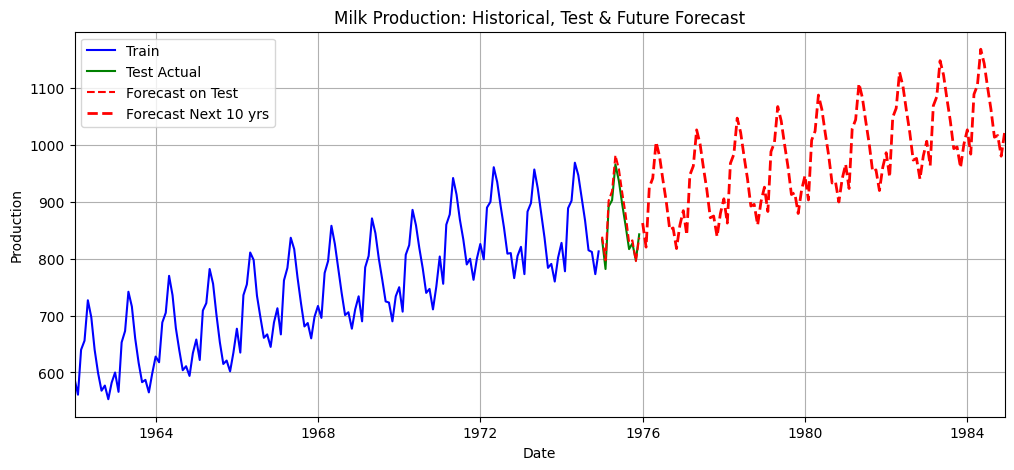

In [120]:
# prompt: evaluate model predictions include mape,mae,rmse error

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_errors(y_true, y_pred):
  """
  Calculates MAPE, MAE, and RMSE errors.

  Args:
    y_true: The actual values.
    y_pred: The predicted values.

  Returns:
    A dictionary containing the MAPE, MAE, and RMSE values.
  """
  # Calculate MAE
  mae = mean_absolute_error(y_true, y_pred)

  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))

  # Calculate MAPE (avoid division by zero)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else float('inf')

  return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# After you generate the forecast on the test set (s_fc_test)
# You can calculate the errors by comparing it to the actual test data (s_test)

# Inside the forecast_and_plot function, after calculating s_fc_test
# You can add the following lines to calculate and print the errors:

# d) wrap into Series
s_train     = df_train['Production']
s_test      = df_test['Production']
s_fc_test   = pd.Series(fc_test,   index=idx_test)
s_fc_future = pd.Series(fc_future, index=idx_future)

# Calculate and print the errors on the test set
test_errors = calculate_errors(s_test, s_fc_test)
print("\nTest Set Evaluation Metrics:")
print(f"  MAE: {test_errors['MAE']:.2f}")
print(f"  RMSE: {test_errors['RMSE']:.2f}")
print(f"  MAPE: {test_errors['MAPE']:.2f}%")

# e) plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(s_train,      color='blue',  linestyle='-',  label='Train')
ax.plot(s_test,       color='green', linestyle='-',  label='Test Actual')
ax.plot(s_fc_test,    color='red',   linestyle='--', label='Forecast on Test')
ax.plot(s_fc_future,  color='red',   linestyle='--', linewidth=2,
        label=f'Forecast Next {years} yrs')

# extend x‐axis
ax.set_xlim(s_train.index[0], s_fc_future.index[-1])

ax.set_title('Milk Production: Historical, Test & Future Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Production')
ax.legend()
ax.grid(True)
plt.show()